In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from morpheus.classifier import Classifier
from morpheus.data import example
%matplotlib inline
import pickle

2022-11-30 19:22:01.899022: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-30 19:22:01.899082: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-30 19:22:02.080575: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-30 19:22:05.314958: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-30 19:22:05.315107: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

# Getting Data H,J,V,z

F160W (H) / F125W (J) / F606W (V) / F850LP (z)

In [8]:
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
f115w_nircam_i2d = (get_pkg_data_filename('/data/jip/2nd_TASK/Morpheus_Trying/JWST_cutout_img_analysis/img/jw01345-o002_t022_nircam_clear-f115w_i2d.fits'))
f150w_nircam_i2d = (get_pkg_data_filename('/data/jip/2nd_TASK/Morpheus_Trying/JWST_cutout_img_analysis/img/jw01345-o002_t022_nircam_clear-f150w_i2d.fits'))
f200w_nircam_i2d = (get_pkg_data_filename('/data/jip/2nd_TASK/Morpheus_Trying/JWST_cutout_img_analysis/img/jw01345-o002_t022_nircam_clear-f200w_i2d.fits'))
f277w_nircam_i2d = (get_pkg_data_filename('/data/jip/2nd_TASK/Morpheus_Trying/JWST_cutout_img_analysis/img/jw01345-o002_t022_nircam_clear-f277w_i2d.fits'))
f356w_nircam_i2d = (get_pkg_data_filename('/data/jip/2nd_TASK/Morpheus_Trying/JWST_cutout_img_analysis/img/jw01345-o002_t022_nircam_clear-f356w_i2d.fits'))
f410m_nircam_i2d = (get_pkg_data_filename('/data/jip/2nd_TASK/Morpheus_Trying/JWST_cutout_img_analysis/img/jw01345-o002_t022_nircam_clear-f410m_i2d.fits'))
f444w_nircam_i2d = (get_pkg_data_filename('/data/jip/2nd_TASK/Morpheus_Trying/JWST_cutout_img_analysis/img/jw01345-o002_t022_nircam_clear-f444w_i2d.fits'))

h, j, v, z = f277w_nircam_i2d, f356w_nircam_i2d, f410m_nircam_i2d, f444w_nircam_i2d

# fits 특성에 따라서 ext 바꿔줘야 
hdat = fits.getdata(h, ext=1)
jdat = fits.getdata(j, ext=1)
vdat = fits.getdata(v, ext=1)
zdat = fits.getdata(z, ext=1)

h_header = fits.getheader(h, ext=1)
j_header = fits.getheader(j, ext=1)
v_header = fits.getheader(v, ext=1)
z_header = fits.getheader(z, ext=1)

# Raw Image Show

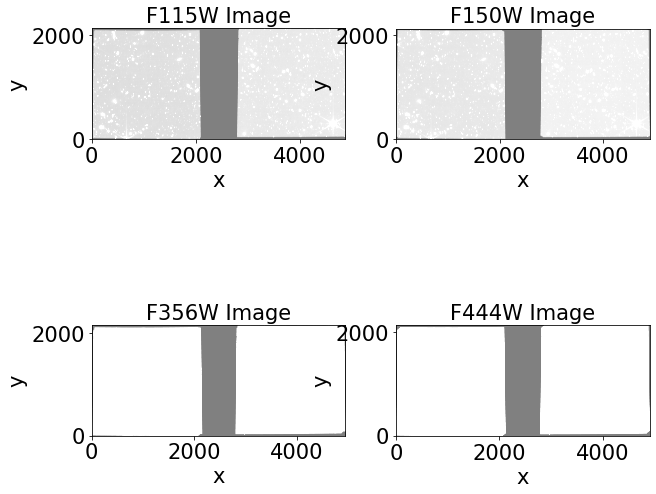

In [9]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = np.array(axes).flatten()
for ax, arr, band in zip(axes, [hdat, jdat, vdat, zdat], ['F115W', 'F150W', 'F356W', 'F444W']):
    ax.set_title(f'{band} Image', fontsize=21)
    ax.imshow(arr, origin='lower', cmap='gray',  vmin=-0.1, vmax=0.1)
    ax.set_xlabel('x', fontsize=21)
    ax.set_ylabel('y', fontsize=21)
    ax.tick_params(axis='x', labelsize=21)
    ax.tick_params(axis='y', labelsize=21)

# Image Cut and Show 

## 1) Given X Y ==> Cut the image


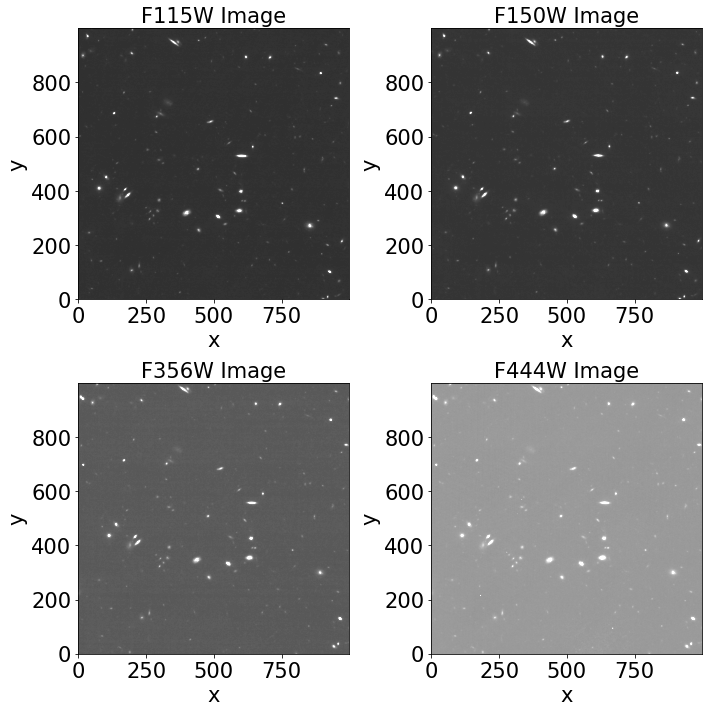

In [10]:

from astropy.nddata import Cutout2D
from astropy import units as u
cutoutposition = (1000, 1000)
cutoutsize = (1000, 1000)
hcut = Cutout2D(hdat, cutoutposition, cutoutsize).data
jcut = Cutout2D(jdat, cutoutposition, cutoutsize).data
vcut = Cutout2D(vdat, cutoutposition, cutoutsize).data
zcut = Cutout2D(zdat, cutoutposition, cutoutsize).data
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = np.array(axes).flatten()

for ax, arr, band in zip(axes, [hcut,jcut,vcut,zcut], ['F115W', 'F150W', 'F356W', 'F444W']):
    ax.set_title(f'{band} Image', fontsize=21)
    ax.imshow(arr, origin='lower', cmap='gray',  vmin=0, vmax=0.3853037)
    ax.set_xlabel('x', fontsize=21)
    ax.set_ylabel('y', fontsize=21)
    ax.tick_params(axis='x', labelsize=21)
    ax.tick_params(axis='y', labelsize=21)

plt.tight_layout()
plt.show()


## 2) Given RA/DEC ==> Cut the image

In [6]:
cutoutposition_radec = [[14, 19, 19.023], [52, 53, 41.14]] #RA(hour, min, sec), DEC(deg, min, sec)형식
def skycoord(x):
    ra = (x[0][0]+x[0][1]/60+x[0][2]/3600)*15*u.deg
    dec = (x[1][0]+x[1][1]/60+x[1][2]/3600)*u.deg
    c = SkyCoord(ra, dec)
    return c

cutoutposition = np.array(skycoord_to_pixel(skycoord(cutoutposition_radec), wcs=wcs_h))
cutoutposition


NameError: name 'skycoord_to_pixel' is not defined

Set DATE-AVG to '2022-06-21T23:30:42.583' from MJD-AVG.
Set DATE-END to '2022-06-22T00:03:43.515' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.785729 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725461621.089 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-22T00:41:54.035' from MJD-AVG.
Set DATE-END to '2022-06-22T01:14:35.286' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.795264 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725510974.395 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-22T01:53:47.550' from MJD-AVG.
Set DATE-END to '2022-06-22T02:27:14.386' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.800090 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725535860.995 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-22T02:59:46.731' from MJD-AVG.
Set DATE-END to '2022-06-22T03:26:17.615' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.812393 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725599046.468 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


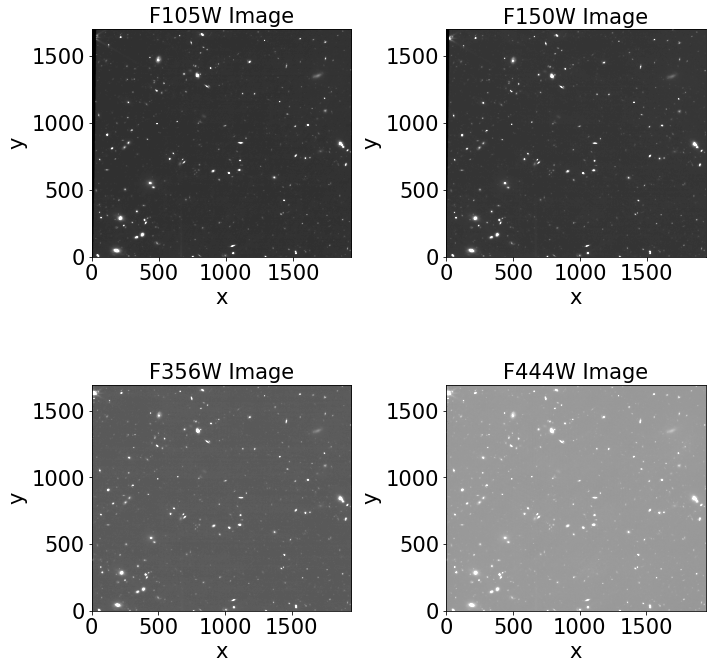

In [ ]:
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

wcs_h = WCS(h_header)
wcs_j = WCS(j_header)
wcs_v = WCS(v_header)
wcs_z = WCS(z_header)

cutoutposition_radec = [[14, 19, 28], [52, 53, 42]] #RA(hour, min, sec), DEC(deg, min, sec)형식
squarecutpoint_radec =  [[14, 19, 19.023], [52, 53, 41.14]] #RA(hour, min, sec), DEC(deg, min, sec)형식

def skycoord(x):
    ra = (x[0][0]+x[0][1]/60+x[0][2]/3600)*15*u.deg
    dec = (x[1][0]+x[1][1]/60+x[1][2]/3600)*u.deg
    c = SkyCoord(ra, dec)
    #print(c)
    return c

def cutoutreturn(cutoutposition_radec, squarecutpoint_radec, wcs):
    cutoutposition = np.array(skycoord_to_pixel(skycoord(cutoutposition_radec), wcs))
    squarecutpoint = np.array(skycoord_to_pixel(skycoord(squarecutpoint_radec), wcs))
    #print(cutoutposition)
    #print(squarecutpoint)
    cutoutsize = abs(squarecutpoint-cutoutposition) * 2
    #print(cutoutsize)
    return np.array([cutoutposition, cutoutsize])
    
hcut = Cutout2D(hdat, cutoutreturn(cutoutposition_radec, squarecutpoint_radec, wcs=wcs_h)[0], cutoutreturn(cutoutposition_radec, squarecutpoint_radec, wcs=wcs_h)[1]).data
jcut = Cutout2D(jdat, cutoutreturn(cutoutposition_radec, squarecutpoint_radec, wcs=wcs_j)[0], cutoutreturn(cutoutposition_radec, squarecutpoint_radec, wcs=wcs_j)[1]).data
vcut = Cutout2D(vdat, cutoutreturn(cutoutposition_radec, squarecutpoint_radec, wcs=wcs_v)[0], cutoutreturn(cutoutposition_radec, squarecutpoint_radec, wcs=wcs_v)[1]).data
zcut = Cutout2D(zdat, cutoutreturn(cutoutposition_radec, squarecutpoint_radec, wcs=wcs_z)[0], cutoutreturn(cutoutposition_radec, squarecutpoint_radec, wcs=wcs_z)[1]).data
#jcut = Cutout2D(jdat, cutoutposition, cutoutsize).data
#vcut = Cutout2D(vdat, cutoutposition, cutoutsize).data
#zcut = Cutout2D(zdat, cutoutposition, cutoutsize).data

f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = np.array(axes).flatten()
for ax, arr, band in zip(axes, [hcut,jcut,vcut,zcut], ['F105W', 'F150W', 'F356W', 'F444W']):
    ax.set_title(f'{band} Image', fontsize=21)
    ax.imshow(arr, origin='lower', cmap='gray',  vmin=-0, vmax=0.38530371)
    ax.set_xlabel('x', fontsize=21)
    ax.set_ylabel('y', fontsize=21)
    ax.tick_params(axis='x', labelsize=21)
    ax.tick_params(axis='y', labelsize=21)

plt.tight_layout()
plt.show()

### image resizing for Morpheus (same size로) --> 추후 반드시 해결할 것 PIL VS cv2 

In [68]:
from PIL import Image
import cv2 

hcut_resize = cv2.resize(hcut, dsize=np.shape(hcut), interpolation=cv2.INTER_NEAREST)
jcut_resize = cv2.resize(jcut, dsize=(np.shape(hcut)))
vcut_resize = cv2.resize(vcut, dsize=(np.shape(hcut)))
zcut_resize = cv2.resize(zcut, dsize=(np.shape(hcut)))



/home/jip/anaconda3/lib/python3.9/site-packages/matplotlib/image.py:479: RuntimeWarning: overflow encountered in subtract
  A_scaled -= a_min
/home/jip/anaconda3/lib/python3.9/site-packages/matplotlib/image.py:480: RuntimeWarning: overflow encountered in subtract
  vrange -= a_min
/home/jip/anaconda3/lib/python3.9/site-packages/matplotlib/image.py:503: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / frac)
/home/jip/anaconda3/lib/python3.9/site-packages/matplotlib/colors.py:1254: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/jip/anaconda3/lib/python3.9/site-packages/matplotlib/image.py:505: RuntimeWarning: overflow encountered in add
  A_resampled += a_min


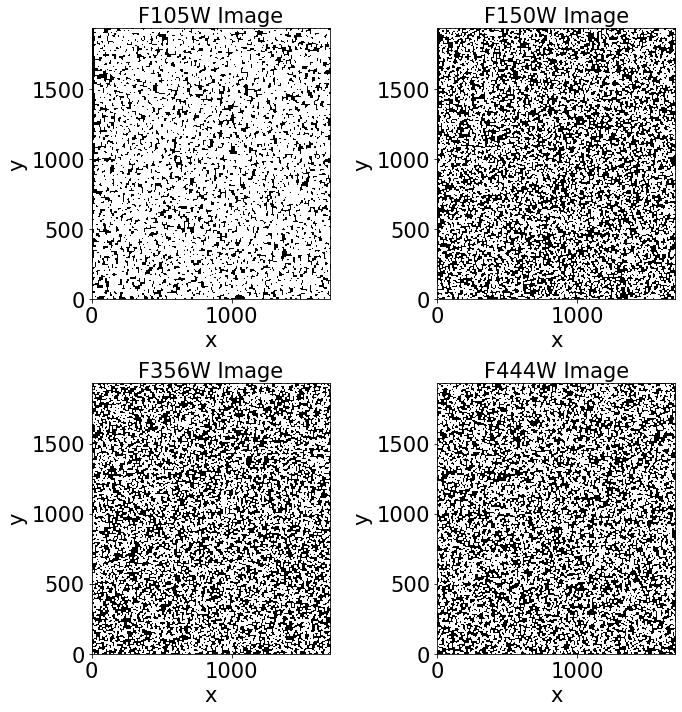

In [67]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = np.array(axes).flatten()
for ax, arr, band in zip(axes, [hcut_resize,jcut_resize,vcut_resize,zcut_resize], ['F105W', 'F150W', 'F356W', 'F444W']):
    ax.set_title(f'{band} Image', fontsize=21)
    ax.imshow(arr, origin='lower', cmap='gray')#,  vmin=0, vmax=0.38530371)
    ax.set_xlabel('x', fontsize=21)
    ax.set_ylabel('y', fontsize=21)
    ax.tick_params(axis='x', labelsize=21)
    ax.tick_params(axis='y', labelsize=21)

plt.tight_layout()
plt.show()

# Running Morpheus

In [18]:
classified = Classifier.classify(h=hcut, j=jcut, v=vcut, z=zcut)



# the mask tells the segmentation mapping algorithm to ignore
# the areas unclassified as a result of the windowing classification
# method used.
mask = np.zeros_like(hcut, np.int)
mask[5:-5, 5:-5] = 1
segmap = Classifier.segmap_from_classified(classified, hcut, mask=mask)

catalog = Classifier.catalog_from_classified(classified, hcut, segmap)

rgb = Classifier.colorize_classified(classified)


classifying:   0%|          | 0/923 [00:00<?, ?batch/s]/home/jip/anaconda3/lib/python3.9/site-packages/morpheus/core/unet.py:143: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  return LAYERS.batch_normalization(inputs, training=is_training, axis=axis)
/home/jip/anaconda3/lib/python3.9/site-packages/morpheus/core/unet.py:162: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  inputs = LAYERS.conv2d(
/home/jip/anaconda3/lib/python3.9/site-packages/morpheus/core/unet.py:149: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  return LAYERS.dropout(inputs, rate=rate)


Building Markers...
Watershedding...


100%|██████████| 1000/1000 [00:01<00:00, 569.11it/s]


# Saving Morpheus Classified Result to Pickle

Once calculation is done to here, don't need to calculate again.

In [21]:
# save with it 
with open("classified_result.pickle","wb") as f:
    pickle.dump(classified, f)

In [2]:
# load with it
with open("classified_result.pickle","rb") as fi:
    classified = pickle.load(fi)

# Colorizing Result

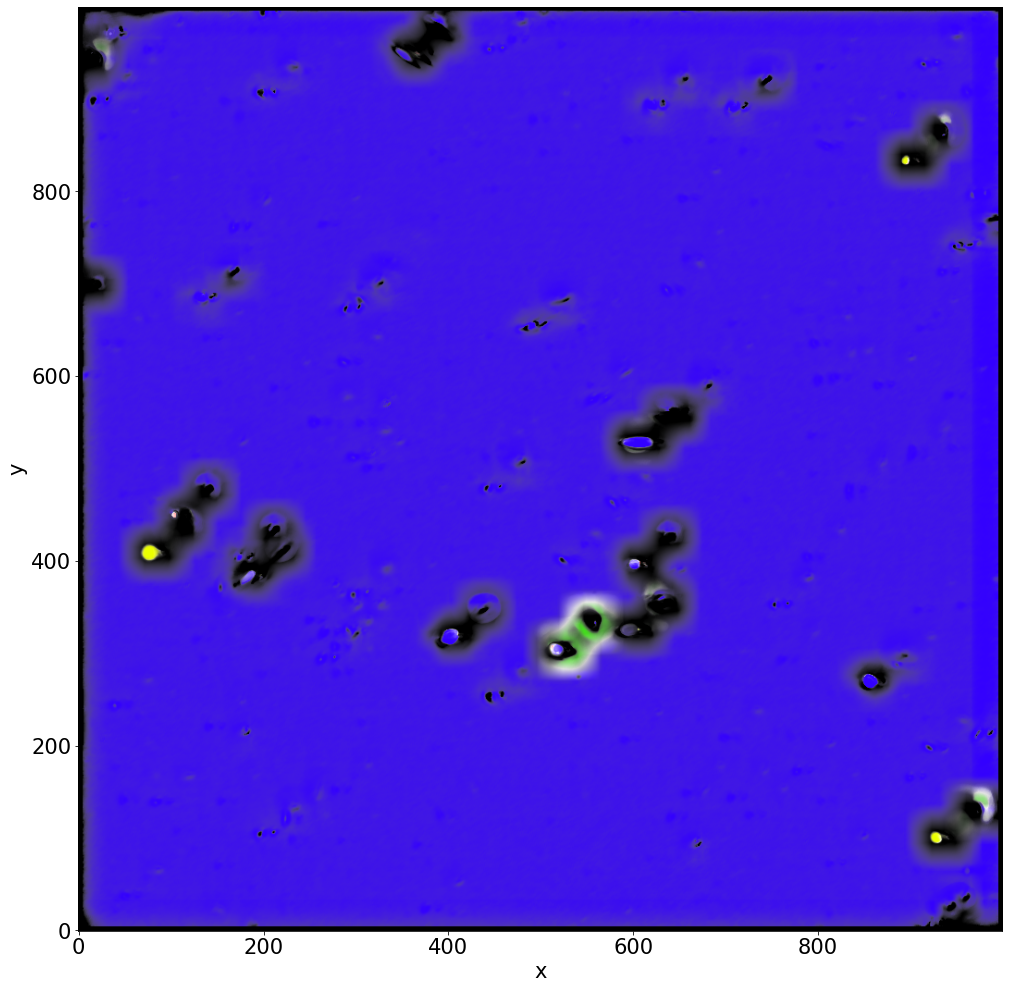

In [5]:
plt.figure(figsize=(17, 17))
plt.xlabel('x', fontsize=21)
plt.ylabel('y', fontsize=21)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.imshow(rgb, origin='lower')
plt.show()

# Saving Result to Dataframe, CSV

In [23]:
from astropy.wcs.utils import pixel_to_skycoord
from astropy.wcs import WCS

wcs = WCS(h_header)

morpheus_result = pd.DataFrame(catalog)
morpheus_result['ra'] = pd.Series(dtype='float')
morpheus_result['dec'] = pd.Series(dtype='float')
morpheus_result['x'] = pd.Series(dtype='float')
morpheus_result['y'] = pd.Series(dtype='float')
morpheus_result['p_sph'] = pd.Series(dtype='float')
morpheus_result['p_disk'] = pd.Series(dtype='float')
morpheus_result['p_irr'] = pd.Series(dtype='float')
morpheus_result['p_ps'] = pd.Series(dtype='float')

for i in range(np.size(morpheus_result['ra'])):
    morpheus_result['x'][i] = morpheus_result['location'][i][1]
    morpheus_result['y'][i] = morpheus_result['location'][i][0]
    morpheus_result['p_sph'][i] = morpheus_result['morphology'][i][0]
    morpheus_result['p_disk'][i] = morpheus_result['morphology'][i][1]
    morpheus_result['p_irr'][i] = morpheus_result['morphology'][i][2]
    morpheus_result['p_ps'][i] = morpheus_result['morphology'][i][3]
   
morpheus_result['real_x'] = morpheus_result['x']+(cutoutposition[0]-cutoutsize[0]/2)
morpheus_result['real_y'] = morpheus_result['y']+(cutoutposition[1]-cutoutsize[1]/2)

for i in range(np.size(morpheus_result['ra'])):
    morpheus_result['ra'][i] = pixel_to_skycoord(morpheus_result['real_x'][i], morpheus_result['real_y'][i], wcs).ra.degree
    morpheus_result['dec'][i] = pixel_to_skycoord(morpheus_result['real_x'][i], morpheus_result['real_y'][i], wcs).dec.degree


Set DATE-AVG to '2022-06-21T23:30:42.583' from MJD-AVG.
Set DATE-END to '2022-06-22T00:03:43.515' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.785729 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725461621.089 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/tmp/ipykernel_8177/2421671279.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_8177/2421671279.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_8177/2421671279.py:19: SettingWithCopyWarning: 
A value is trying to be set

In [24]:
import os 
# os.makedirs("./output")
morpheus_result.to_csv("./morpheus_result.csv")

# Filtering High-Probabilithy Disk Candidates

In [25]:
datmor = pd.DataFrame(pd.read_csv("morpheus_result.csv"))
datmor_highdisk=datmor.loc[datmor['p_disk'] > 0.5]
datmor_highdisk

,Unnamed: 0,id,location,morphology,ra,dec,x,y,p_sph,p_disk,p_irr,p_ps,real_x,real_y
0,0,4,"[304, 517]","[0.004214043399937225, 0.9745820631016608, 0.0...",214.862743,52.898298,517.0,304.0,4.214043e-03,0.974582,1.886219e-02,2.341703e-03,1017.0,804.0
1,1,5,"[408, 78]","[0.0012955463222598617, 0.9025014887019072, 0....",214.856740,52.891283,78.0,408.0,1.295546e-03,0.902501,8.731635e-04,9.532980e-02,578.0,908.0
2,2,6,"[101, 928]","[0.0018090313608277188, 0.9656217115435171, 0....",214.866039,52.906069,928.0,101.0,1.809031e-03,0.965622,3.729508e-03,2.883975e-02,1428.0,601.0
3,3,7,"[528, 604]","[0.00047018126190971225, 0.9971817918259157, 0...",214.869317,52.896900,604.0,528.0,4.701813e-04,0.997182,2.236484e-03,1.115433e-04,1104.0,1028.0
4,4,8,"[396, 601]","[0.057353506713164845, 0.8984933610714578, 0.0...",214.866355,52.898365,601.0,396.0,5.735351e-02,0.898493,2.546363e-02,1.868950e-02,1101.0,896.0
5,5,9,"[449, 104]","[0.0419140120102371, 0.9538990400694616, 0.004...",214.858134,52.891161,104.0,449.0,4.191401e-02,0.953899,4.067558e-03,1.193895e-04,604.0,949.0
6,6,10,"[969, 36]","[0.0021848107848884946, 0.9832647873252558, 0....",214.868294,52.884332,36.0,969.0,2.184811e-03,0.983265,1.420346e-02,3.469460e-04,536.0,1469.0
7,7,11,"[404, 174]","[0.00020002360984208354, 0.9993222953544625, 6...",214.858465,52.892603,174.0,404.0,2.000236e-04,0.999322,6.249075e-06,4.714320e-04,674.0,904.0
8,8,12,"[270, 855]","[0.00017900738165674694, 0.9998208253053665, 1...",214.868380,52.903174,855.0,270.0,1.790074e-04,0.999821,1.178812e-07,4.943177e-08,1355.0,770.0
9,9,13,"[891, 708]","[8.452255872097873e-05, 0.9999154774412791, 0....",214.879272,52.894144,708.0,891.0,8.452256e-05,0.999915,0.000000e+00,0.000000e+00,1208.0,1391.0


# Plotting detected sources on image and colormap

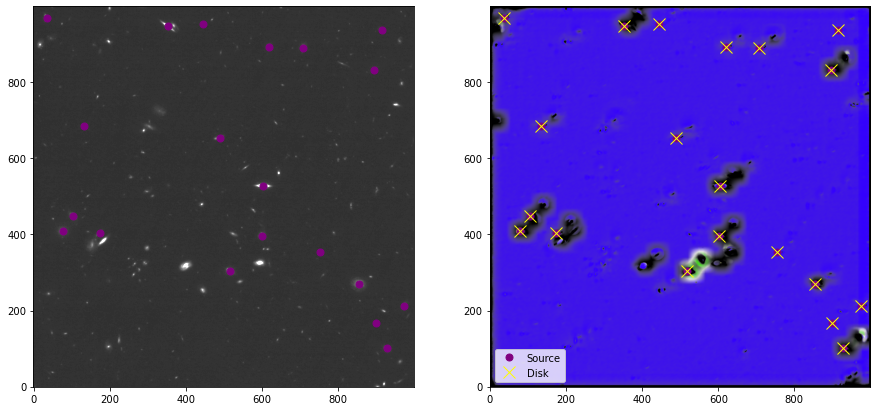

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(hcut, origin='lower', cmap='gray',  vmin=0, vmax=0.38)
axs[0].plot(datmor['x'], datmor['y'], 'o', ms=7, color='purple')
axs[1].imshow(rgb, origin='lower')
axs[1].plot(datmor['x'], datmor['y'], 'o', ms=7, color='purple', label='Source')
axs[1].plot(datmor_highdisk['x'], datmor_highdisk['y'], 'x', ms=12, color='yellow', label='Disk')
axs[1].legend()


Red = Spheroid <br>
Blue = Disk <br>
Green = Irregular <br>
Yellow = Point Source (compact) <br>
Back = Background <br>
White = Can't Classify (two class prob is so similar) <br>